# how to generate maze

This notebook explains how to generate a random maze.

We explain an algorithm to generate a maze with rough boundaries so that it becomes challenging to navigate the maze with a controllable avatar.
This kind of random maze is usaful for some research projects related to input and output for remote vehicle control.

## what kind of maze?

This algorithm makes a mazing satstifying the following conditions
- single path
- enterance and exit exists
- the width of the path should be larger than a certain threshold

## concept

(explain concept here)

In [80]:
num_coarse_cells_row = 10
num_coarse_cells_col = 10

# the percentage of coarse path cells in the maze
path_percentage = 0.3

# per coarse cell
num_fine_cells_row = 10
num_fine_cells_col = 10

# drone size (min maze path width), relative to fine cell size
drone_size = 2
max_wall_grow_steps = 500

In [81]:
import numpy as np
import random

def create_coarse_maze():
    coarse_maze = create_random_coarse_maze()
    cell_percentage = calculate_cell_percentage(coarse_maze)
    while cell_percentage < path_percentage:
        coarse_maze = create_random_coarse_maze()
        cell_percentage = calculate_cell_percentage(coarse_maze)

    return coarse_maze

def calculate_cell_percentage(maze: np.ndarray) -> float:
    return np.mean(1 - maze)

def create_random_coarse_maze():
    coarse_maze = np.ones((num_coarse_cells_row, num_coarse_cells_col), dtype=np.uint8)

    # randomly pick the entry
    entry_row = np.random.randint(1, num_coarse_cells_row - 1)
    entry_col = 0

    coarse_maze[entry_row, entry_col] = 0
    cursor = (entry_row, entry_col)

    while True:
        next_cell = select_next_random_cell(coarse_maze, cursor[0], cursor[1])
        if (next_cell):
            coarse_maze[next_cell[0], next_cell[1]] = 0
            cursor = next_cell
            
            if is_on_the_map_boundary(coarse_maze, cursor[0], cursor[1]):
                # cursor is on the edge of the map
                # this will be the exit point
                break
        else:
            break

    return coarse_maze

def select_next_random_cell(maze: np.ndarray, current_row: int, current_col: int) -> (int, int):
    """Select a random cell that is not visited, not adjacent to the visited cells, and not at the boundary """
    n_maze_row = maze.shape[0]
    n_maze_col = maze.shape[1]
    
    valid_next_cells:list[(int, int)] = []

    def is_cell_valid(row: int, col: int) -> bool:
        return is_in_the_map(maze, row, col) and is_not_visited(maze, row, col) and is_not_adjacent_to_visited(maze, current_row, current_col, row, col)

    # check 4 adjacent cells
    if is_cell_valid(current_row - 1, current_col):
        valid_next_cells.append((current_row - 1, current_col))

    if is_cell_valid(current_row + 1, current_col):
        valid_next_cells.append((current_row + 1, current_col))

    if is_cell_valid(current_row, current_col + 1):
        valid_next_cells.append((current_row, current_col + 1))

    if is_cell_valid(current_row, current_col - 1):
        valid_next_cells.append((current_row, current_col - 1))

    if len(valid_next_cells) == 0:
        return None
    
    return random.choice(valid_next_cells)

def is_in_the_map(maze: np.ndarray, row: int, col: int) -> bool:
    n_maze_row = maze.shape[0]
    n_maze_col = maze.shape[1]
    return 0 <= row < n_maze_row and 0 <= col < n_maze_col

def is_on_the_map_boundary(maze: np.ndarray, row: int, col: int) -> bool:
    n_maze_row = maze.shape[0]
    n_maze_col = maze.shape[1]
    return 0 == row or row == n_maze_row - 1 or 0 == col or col == n_maze_col - 1

def is_not_visited(maze: np.ndarray, row: int, col: int) -> bool:
    return maze[row, col] == 1

def is_not_adjacent_to_visited(maze: np.ndarray, current_row: int, current_col: int, next_row: int, next_col: int) -> bool:
    if not is_in_the_map(maze, next_row, next_col):
        return False

    adjacent_cells_except_current = []
    for cell in [(next_row-1, next_col), (next_row+1, next_col), (next_row, next_col+1), (next_row, next_col-1)]:
        if not is_in_the_map(maze, cell[0], cell[1]):
            continue

        if cell != (current_row, current_col):
            adjacent_cells_except_current.append(cell)

    for cell in adjacent_cells_except_current:
        if (maze[cell[0], cell[1]] == 0):
            return False

    return True

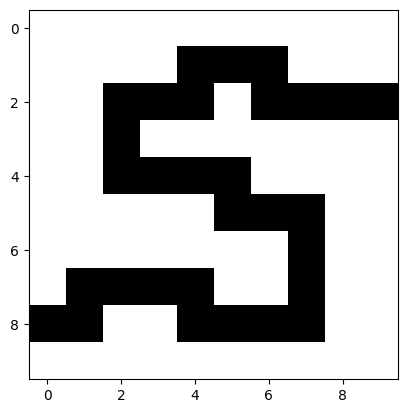

In [82]:
import numpy as np
from matplotlib import pyplot as plt

coarse_maze = create_coarse_maze()

plt.imshow(coarse_maze, cmap='gray')


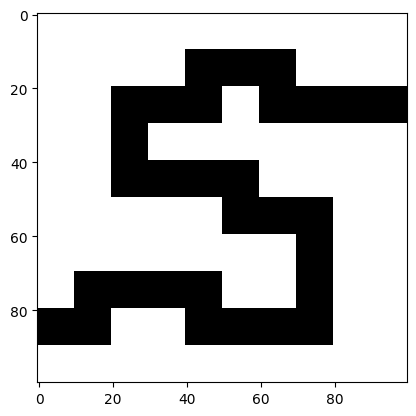

In [83]:
sub_cell = np.ones((num_fine_cells_row, num_fine_cells_col), dtype=np.uint8)

# Kronecker multiplication
maze = np.kron(coarse_maze, sub_cell)
plt.imshow(maze, cmap='gray')

connect diangonally touching blocks

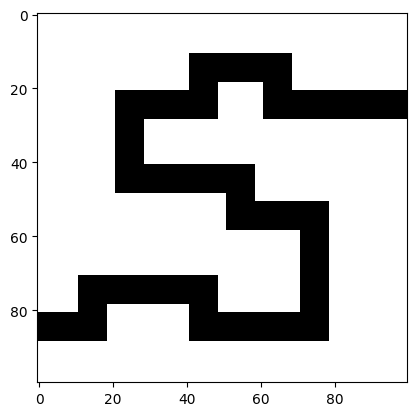

In [84]:
from scipy import ndimage

kernal = np.array([[1, 0, 1], [0, 1, 0], [1, 0, 1]])
conved_maze = ndimage.convolve(maze, kernal, mode='constant', cval=0)
conved_maze[conved_maze > 0] = 1

plt.imshow(conved_maze, cmap='gray')


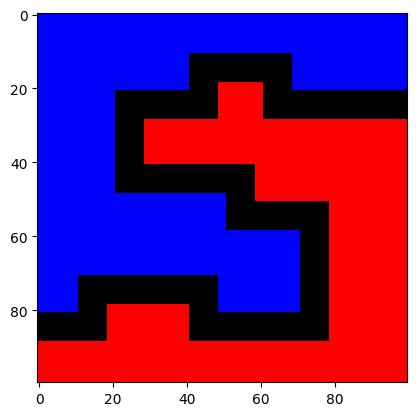

In [85]:
from matplotlib.colors import ListedColormap

labeled_maze, num_features = ndimage.label(conved_maze)

cmap = ListedColormap(['black', 'blue', 'red'])
plt.imshow(labeled_maze, cmap)

## split compoenents

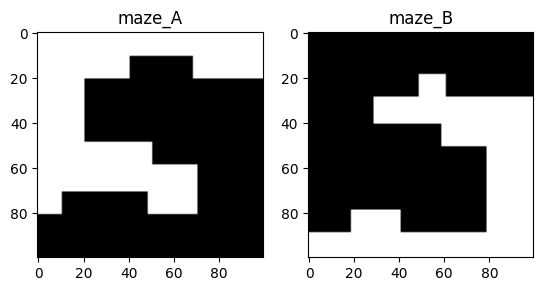

In [86]:
def split_components(maze:np.ndarray, labeled_maze: np.ndarray) -> (np.ndarray, np.ndarray):
    # ensure paths are 0 and the other compoents are >0
    binary_maze = maze * (labeled_maze + 1)
    labels = np.unique(binary_maze)
    label_A = np.median(labels)
    label_B = np.max(labels)

    maze_A = np.zeros_like(binary_maze)
    maze_A[binary_maze == label_A] = 1
    maze_B = np.zeros_like(binary_maze)
    maze_B[binary_maze == label_B] = 1

    return (maze_A, maze_B)

maze_A, maze_B = split_components(conved_maze, labeled_maze)

fig, axs = plt.subplots(1, 2)
axs[0].set_title('maze_A')
axs[1].set_title('maze_B')
axs[0].imshow(maze_A, cmap='gray')
axs[1].imshow(maze_B, cmap='gray')


## iteration: select boundary points and measure distances

Text(0.5, 1.0, 'Boundary points of maze A')

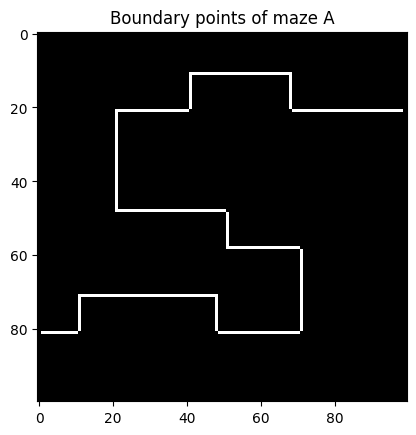

In [87]:
def select_random_boundary_points(maze: np.ndarray) -> list[(int, int)]:
    n_maze_row = maze.shape[0]
    n_maze_col = maze.shape[1]

    cross_kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])
    kernel_sum = np.sum(cross_kernel)

    conved_maze = ndimage.convolve(maze, cross_kernel, mode='constant', cval=1)

    boundary_points = np.argwhere((conved_maze < kernel_sum) & (conved_maze > 0))

    # exclude the map boundary
    boundary_points = filter(lambda x: not is_on_the_map_boundary(maze, x[0], x[1]), boundary_points)
    # exclude the walls
    boundary_points = filter(lambda x: maze[x[0], x[1]] == 0, boundary_points)
    
    return list(boundary_points)

boundary_points_A = select_random_boundary_points(maze_A)
empty_maze = np.zeros_like(maze_A)

for point in boundary_points_A:
    empty_maze[point[0], point[1]] = 1

plt.imshow(empty_maze, cmap='gray')
plt.title('Boundary points of maze A')

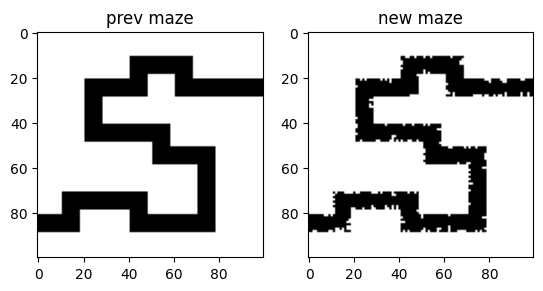

In [88]:
def select_random_boundary_point(component_maze: np.ndarray) -> (int, int):
    boundary_points = select_random_boundary_points(component_maze)
    return random.choice(boundary_points)

def calculate_min_dist_to_point(maze: np.ndarray, row: int, col: int) -> int:
    boundary_points = select_random_boundary_points(maze)
    distances = [abs(row - point[0]) + abs(col - point[1]) for point in boundary_points]
    return min(distances)


def add_random_wall_point(maze_A: np.ndarray, maze_B: np.ndarray, min_path_width: float) -> (np.ndarray, np.ndarray):
    maze_to_add_point = random.choice([maze_A, maze_B])
    add_point_to_maze_A = maze_to_add_point is maze_A
    other_maze = maze_A if maze_to_add_point is maze_B else maze_B
    
    random_boudary_point = select_random_boundary_point(maze_to_add_point)

    min_dist_to_point = calculate_min_dist_to_point(other_maze, random_boudary_point[0], random_boudary_point[1])
    
    if min_dist_to_point < min_path_width:
        return (maze_A, maze_B)

    copied_maze_A = maze_A.copy()
    copied_maze_B = maze_B.copy()
    if add_point_to_maze_A:
        copied_maze_A[random_boudary_point[0], random_boudary_point[1]] = 1
    else:
        copied_maze_B[random_boudary_point[0], random_boudary_point[1]] = 1

    return copied_maze_A, copied_maze_B


iter_count = 0
while iter_count < max_wall_grow_steps:
    maze_A, maze_B = add_random_wall_point(maze_A, maze_B, min_path_width=drone_size)
    iter_count += 1

new_maze = maze_A + maze_B

fig, axs = plt.subplots(1, 2)
axs[0].set_title('prev maze')
axs[1].set_title('new maze')
axs[0].imshow(conved_maze, cmap='gray')
axs[1].imshow(new_maze, cmap='gray')
